# TF Simple MLP

In [1]:
import tensorflow as tf
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from datetime import datetime
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
mnist = fetch_mldata("MNIST original", data_home="/home/saurabh/Documents/python/digits/data")

X_train, X_test, y_train, y_test = train_test_split(mnist.data, label_binarize(mnist.target, classes = range(10)))

In [3]:
print ('Shape of X : {}'.format(X_train[0].shape))
print ('Shape of y : {}'.format(y_train[0].shape))

Shape of X : (784,)
Shape of y : (10,)


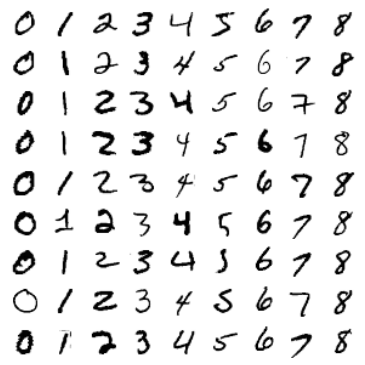

In [4]:
fig = plt.figure(figsize=(7, 7))
for x in range(0, 9):
    for y in range(0, 9):
        ax = fig.add_subplot(10, 10, 10*(y+1)+x + 1)
        index = np.where(mnist.target == x)[0][y]
        ax.imshow(mnist.data[index].reshape((28, 28)))
        ax.axis("off")
        plt.xticks([])
        plt.yticks([])

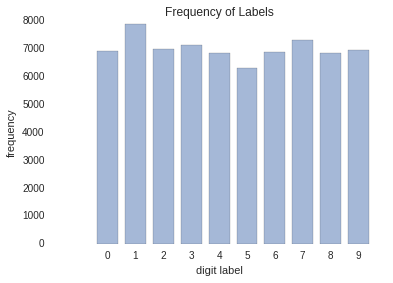

In [5]:
from collections import Counter

frequency = Counter(mnist.target.reshape(-1).tolist())
x = np.arange(len(frequency.keys()))
width = .75
fig, ax = plt.subplots()
ax.set_frame_on(False)
ax.bar(x , frequency.values(), width, align = "center", edgecolor = "none", alpha = .5)
ax.set_xticks(x + width)
plt.xticks(range(0, 10), [str(i) for i in range(0 , 10)])
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_title("Frequency of Labels")
ax.set_xlabel("digit label")
ax.set_ylabel("frequency");

## Build Network of 2 hidden layers

In [3]:
def multilayer_perceptron(X, weights, biases):
    layer1 = tf.nn.sigmoid(tf.add(tf.matmul(X, weights["h1"]), biases["b1"]))
    layer2 = tf.nn.sigmoid(tf.add(tf.matmul(layer1, weights["h2"]), biases["b2"]))
    return tf.nn.sigmoid(tf.add(tf.matmul(layer2, weights["out"]), biases["out"]))


## Build model

In [4]:
learning_rate = 0.001
n_hidden1 = 256
n_hidden2 = 128
n_input = 784
n_classes = 10
stddev = 0.1

graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32, [None, n_input])
    y = tf.placeholder(tf.float32, [None, n_classes])


    weights = {
        "h1": tf.Variable(tf.random_normal([n_input, n_hidden1], stddev=stddev)),
        "h2": tf.Variable(tf.random_normal([n_hidden1, n_hidden2], stddev=stddev)),
        "out": tf.Variable(tf.random_normal([n_hidden2, n_classes], stddev=stddev))
    }

    biases = {
        "b1": tf.Variable(tf.random_normal([n_hidden1])),
        "b2": tf.Variable(tf.random_normal([n_hidden2])),
        "out": tf.Variable(tf.random_normal([n_classes]))
    }


    prediction = multilayer_perceptron(X, weights, biases)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(prediction, y))
    train_step = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

    correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    saver = tf.train.Saver()

| s_no |       time |       cost |  train_accuracy |     cv_accuracy |
|----- | ---------- | ---------- | --------------- | --------------- |
|    1 |  0.194 min |       1.73 |          87.0 % |          91.0 % | 
|    2 |  0.176 min |       1.56 |          97.0 % |          96.0 % | 
|    3 |  0.169 min |       1.54 |          89.0 % |          91.0 % | 
|    4 |  0.158 min |       1.53 |          92.0 % |          97.0 % | 
|    5 |  0.152 min |       1.52 |          91.0 % |          91.0 % | 
|    6 |   0.15 min |       1.52 |          93.0 % |          86.0 % | 
|    7 |  0.155 min |       1.52 |          94.0 % |          89.0 % | 
|    8 |  0.154 min |       1.52 |          95.0 % |          95.0 % | 
|    9 |   0.16 min |       1.51 |          88.0 % |          94.0 % | 
|   10 |  0.182 min |       1.51 |          94.0 % |          94.0 % | 
92.9 %


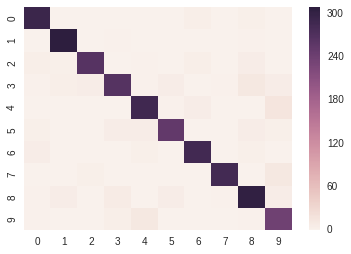

In [6]:
n_epochs = 10
batch_size = 100
n_batches = int(X_train.shape[0] / batch_size)

np.random.seed(1)
train = []
cv = []
costs = []

with tf.Session(graph=graph) as sess:
    sess.run(tf.initialize_all_variables())
    headers = ["s_no", "time", "cost", "train_accuracy", "cv_accuracy"]
    print "|{0:>5} | {1:>10} | {2:>10} | {3:>15} | {4:>15} |".format(*headers)
    print "|{0:-<5} | {0:-<10} | {0:-<10} | {0:-<15} | {0:-<15} |".format("")
    for epoch in range(n_epochs):
        avg_cost = 0.0
        start_time = datetime.now()
        for _ in range(n_batches):
            
            indices = np.random.randint(X_train.shape[0], size=batch_size)
            sess.run(train_step, { X: X_train[indices], y: y_train[indices]})
            avg_cost += sess.run(cost, { X: X_train[indices], y: y_train[indices]}) / float(n_batches)
    
        indices = np.random.randint(X_train.shape[0], size=batch_size)
        score_train = sess.run(accuracy, { X: X_train[indices], y: y_train[indices]})
        indices = np.random.randint(X_test.shape[0], size=batch_size)
        score_valid = sess.run(accuracy, { X: X_test[indices], y: y_test[indices]})
        
        end_time = datetime.now()
        print ("|{0:>5} | {1:>6.3} min | {2:>10.2f} | {3:>13.1f} % | {4:>13.1f} % | ".format(
                 epoch + 1, (end_time - start_time).total_seconds() / 60.0, avg_cost, 100 * score_train, 100 * score_valid))
        train.append(score_train * 100)
        cv.append(score_valid * 100)
        costs.append(avg_cost)
    indices = np.random.randint(X_test.shape[0], size=3000)
    y_true = np.argmax(y_test[indices], 1)
    y_pred = np.argmax(prediction.eval({ X: X_test[indices] }), 1)
    sns.heatmap(confusion_matrix(y_true, y_pred))
    print "{0:>.1f} %".format(accuracy_score(y_true, y_pred) * 100)
    save_path = saver.save(sess, "saved_models/mnist/MLP_MODEL.ckpt")

In [10]:
with tf.Session(graph=graph) as sess:
    tf.train.write_graph(sess.graph_def, "saved_graphs/mnist", "mlp.pb")

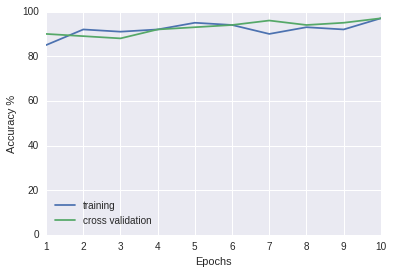

In [20]:
points = {
    "epoch": range(1, len(train) + 1),
    "train": train,
    "cv":    cv
}
plt.plot(points["epoch"], points["train"])
plt.plot(points["epoch"], points["cv"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.ylim((0, 100))
plt.legend(["training", "cross validation"], loc="lower left");

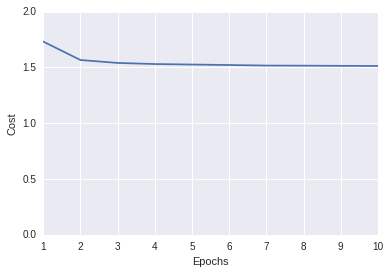

In [23]:
points = {
    "epoch": range(1, len(costs)+1),
    "cost":  costs
}

plt.plot(points["epoch"], points["cost"])
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.ylim((0, 2));